# **Sentiment Analysis on Financial Data**

### **1. Imports and Setups**

#### 1.0. Imports

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
Found existing installation: accelerate 0.19.0
Uninstalling accelerate-0.19.0:
  Successfully uninstalled accelerate-0.19.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
  Using cached accelerate-0.19.0-py3-none-any.whl (219 kB)


In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import nltk
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter, defaultdict

from datasets import Dataset
import torch
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, DistilBertTokenizerFast,DistilBertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 1.1. Setting up GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### **2. Exploratory Data Analysis and Data Processing**

#### **2.1. Understanding the data**

For this project, we are going to use the kaggle Dataset "FinancialPhraseBank", it contains the sentiments for financial news headlines from the perspective of a retail investor.
Here is the link to the dataset: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

Our data contains 4846 observations and no missing values.

The data is partitioned into:
- Neutral: 59.41%
- Positive: 28.13%
- Negative: 12.46%

In [ ]:
url='https://raw.githubusercontent.com/achrafbalij/Sentiment-Analysis-on-Financial-News/main/all-data.csv'
data=pd.read_csv(url, encoding="cp1252",header=None)
data.columns = ['sentiment', 'text']

In [ ]:
data

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
data.shape

(4846, 2)

In [ ]:
data.isna().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
data.sentiment.value_counts()/data.shape[0]

neutral     0.594098
positive    0.281263
negative    0.124639
Name: sentiment, dtype: float64

<Axes: xlabel='sentiment', ylabel='count'>

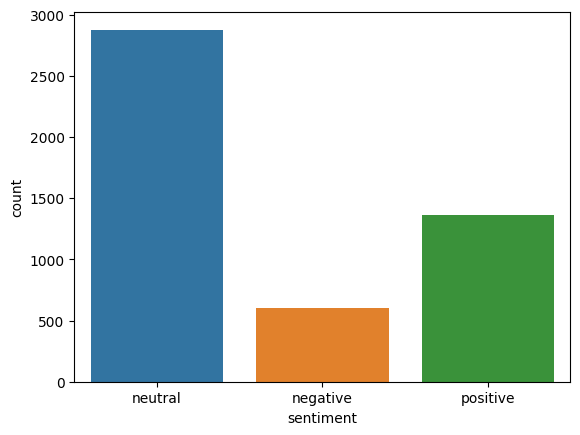

In [ ]:
sns.countplot(x="sentiment", data=data)

#### **2.2. Pre-processing**
#### Data cleaning:
* Remove punctuation.
* Remove stop word.
* Normalize (by applying a Stemmer or a Lemmatizer ).
* Set all characters to lowercase.
* Remove numbers (or convert numbers to * textual representations).


In [ ]:
lemmatizer = WordNetLemmatizer()

def cleaning_data(text):
  text = str(text).lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
  return " ".join(lemma_words)

data['text']=data['text'].map(lambda s:cleaning_data(s))

In [ ]:
data

,sentiment,text
0,neutral,according gran company plan move production ru...
1,neutral,technopolis plan develop stage area le square ...
2,negative,international electronic industry company elco...
3,positive,new production plant company would increase ca...
4,positive,according company updated strategy year baswar...
...,...,...
4841,negative,london marketwatch share price ended lower lon...
4842,neutral,rinkuskiai beer sale fell per cent million lit...
4843,negative,operating profit fell eur eur including vessel...
4844,negative,net sale paper segment decreased eur second qu...


#### **Wordcloud**

Wordcloud is a visual representation of words. It enable anyone to quickly identify and visualize patterns in sentiment data so that insights can be realized, communicated easily and shared among teams

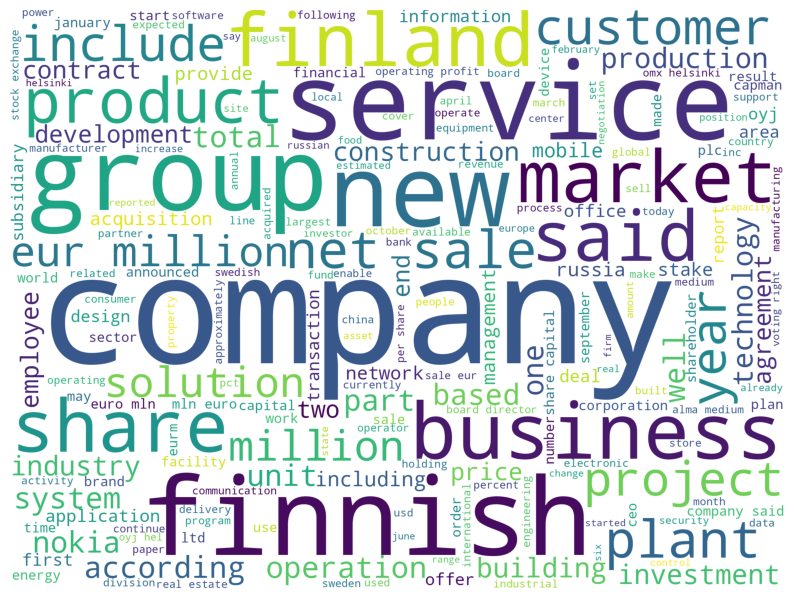

In [ ]:
def plot_wordcloud(data):
  words = ' '.join(data['text'])

  wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        width=2000,
                        height=1500
                      ).generate(words)

  plt.figure(1,figsize=(10, 10))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

plot_wordcloud(data[data['sentiment']=='neutral'])

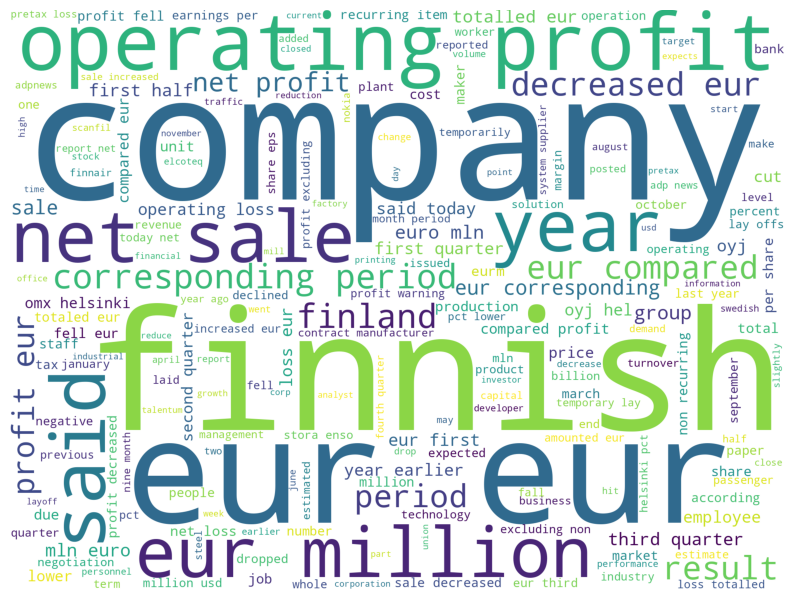

In [ ]:
plot_wordcloud(data[data['sentiment']=='negative'])

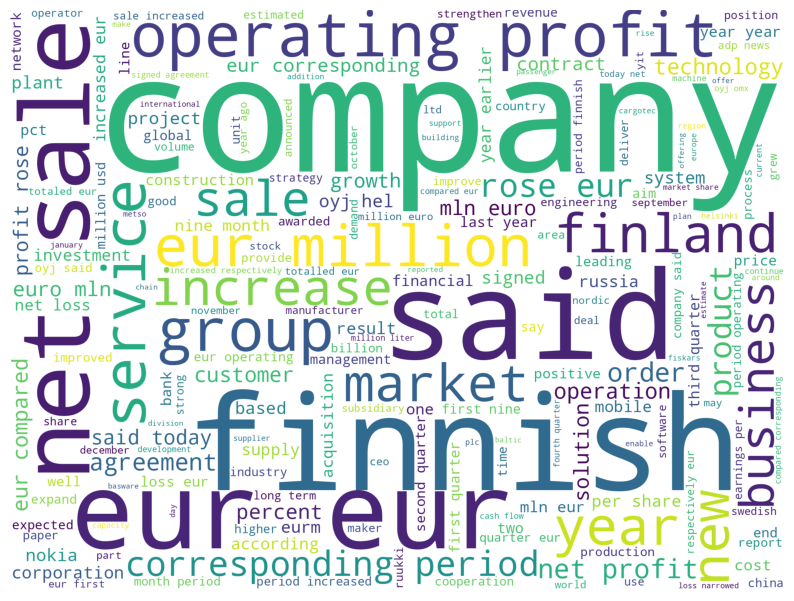

In [ ]:
plot_wordcloud(data[data['sentiment']=='positive'])

#### **Word Frequencies**

In [ ]:
def ngrams(input, n):
    """ INPUT : Sentence and number of n-grams
  OUTPUT N-Grams
  An n-gram is a contiguous sequence of n items from a given sample of text or speech.
  """
    output = []
    for i in range(len(input)-n+1):
        output.append('_'.join(input[i:i+n]))
    return output

In [ ]:
nltk.download('punkt')
tags = ['neutral','negative','positive']

df = data[data.sentiment.isin(tags)]

df['Tokens'] = df.apply(lambda row: nltk.word_tokenize(row['text'].strip()), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
c_unique = Counter()
for ind in df.index:
    c_unique.update(Counter(set(df.loc[ind]['Tokens'])))
print(c_unique)
print('First 20 common words:\n')
for word in c_unique.most_common(20):
    print(word[0],'-->', 'appeared in',word[1],'documents out of {} documents i.e.'.format(len(df)),np.round(100*word[1]/len(df),2),'%')


Counter({'company': 904, 'eur': 801, 'said': 544, 'finnish': 512, 'sale': 473, 'profit': 410, 'year': 390, 'net': 384, 'share': 344, 'finland': 331, 'group': 312, 'million': 311, 'operating': 294, 'service': 287, 'business': 270, 'market': 262, 'new': 261, 'period': 240, 'oyj': 229, 'quarter': 227, 'also': 223, 'first': 181, 'euro': 175, 'product': 175, 'contract': 169, 'operation': 165, 'helsinki': 156, 'solution': 154, 'loss': 149, 'today': 149, 'compared': 147, 'total': 139, 'customer': 138, 'plant': 136, 'system': 134, 'technology': 129, 'order': 129, 'financial': 129, 'mln': 128, 'based': 127, 'investment': 124, 'production': 122, 'according': 121, 'per': 121, 'unit': 121, 'corresponding': 118, 'agreement': 118, 'mobile': 117, 'nokia': 114, 'result': 114, 'project': 114, 'hel': 113, 'month': 112, 'corporation': 112, 'bank': 111, 'well': 108, 'capital': 106, 'one': 106, 'increase': 105, 'value': 104, 'price': 104, 'construction': 103, 'rose': 101, 'industry': 100, 'part': 100, 'inc

 Labeling the data

In [ ]:
sent = data.sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
data['label'] = data.sentiment.replace(label)
data.head()

,sentiment,text,label
0,neutral,according gran company plan move production ru...,0
1,neutral,technopolis plan develop stage area le square ...,0
2,negative,international electronic industry company elco...,1
3,positive,new production plant company would increase ca...,2
4,positive,according company updated strategy year baswar...,2


**Let's split the data now (70% train, 10% validation, 20% test)**

In [ ]:
df_temp, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['sentiment'])

In [ ]:
print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))

size of training set : 3488
size of validation set : 388
size of test set : 970


Because the Data is imbalanced dataset, we will use oversampling as a mean to



fix the imbalance but only on the training set.

In [ ]:
from sklearn.utils import resample

sentiment = data.sentiment.unique()
max = 2
target_majority = data[data.sentiment==sentiment[max]]

for cl in range(3):
    train_minority = df_train[df_train.sentiment==sentiment[cl]]

    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=33)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])
    print(cl,"*****************************************")
    print(train_minority_upsampled)
    print(train_minority)

train_upsampled['sentiment'].value_counts()

0 *****************************************
     sentiment                                               text  label
3961   neutral  finnish law parliament grant licence build nuc...      0
4181   neutral  atrium said offer would give swedish company c...      0
1510   neutral  change built model design communicated subcont...      0
628    neutral  alexandria oct aaron moss hampshire great brit...      0
3503   neutral  according finnish financial service group samp...      0
...        ...                                                ...    ...
2162   neutral     net sale totalled eur million operating margin      0
1612   neutral  company also appointed leif rosen head special...      0
2720   neutral                                   happen overnight      0
503    neutral  sanoma continue focus investing digital medium...      0
3884   neutral             oulu plant employ approximately people      0

[1363 rows x 3 columns]
     sentiment                                         

negative    1363
neutral     1363
positive    1363
Name: sentiment, dtype: int64

In [ ]:
len(set(train_upsampled[train_upsampled['label']==1].index))

419

<Axes: xlabel='sentiment', ylabel='count'>

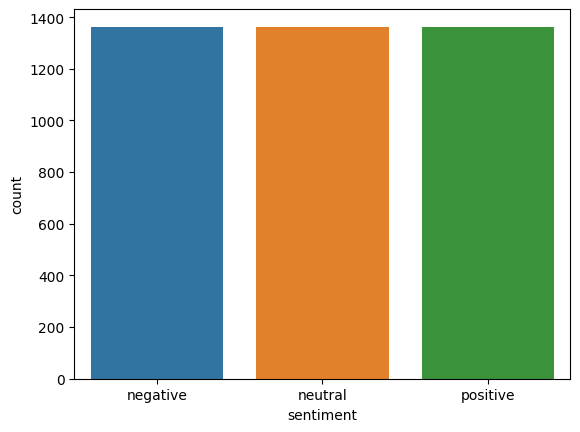

In [ ]:
sns.countplot(x="sentiment", data=train_upsampled)

<Axes: xlabel='sentiment', ylabel='count'>

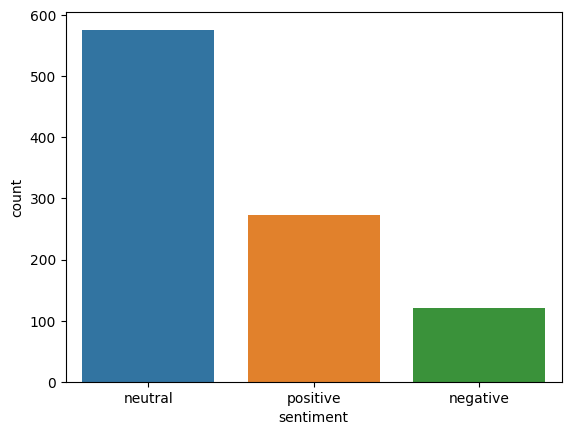

In [ ]:
sns.countplot(x="sentiment", data=df_test)

### **3. Classification model**

**3.1. Baseline: TF-IDF And Naive Bayes Classifier**

In [ ]:
X_train = train_upsampled['text']
y_train = train_upsampled['label']

X_val = df_val['text']
y_val = df_val['label']

X_test = df_test['text']
y_test = df_test['label']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
 	('transformer', Pipeline([
 		('vect', CountVectorizer()),
 		('tfidf', TfidfTransformer())
 	])),
 	('clf', MultinomialNB())
])

pipeline.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('clf', MultinomialNB())])

In [ ]:
def labels(x):
  if x == 0:
    return 'neutral'
  elif x == 1:
    return 'negative'
  else:
    return 'positive'

df_test_NB = df_test.copy()
predictions = pipeline.predict(X_test)

df_test_NB['Sentiment_pred'] = predictions
df_test_NB['Sentiment_pred'] = df_test_NB['Sentiment_pred'].map(labels)

df_test_NB['pred_label'] = predictions

df_test_NB.head()

,sentiment,text,label,Sentiment_pred,pred_label
2108,neutral,following payment made april company total eur...,0,neutral,0
4276,neutral,share subscription period option commence sept...,0,negative,1
478,neutral,aspocomp intends set plant manufacture printed...,0,neutral,0
810,positive,finnish rautaruukki awarded contract supply in...,2,positive,2
4648,negative,finnish bank _land report operating profit fel...,1,negative,1


#### **Classification report of TF-IDF And Naive Bayes Classifier**

In [ ]:
print('Classification_report of TF-IDF And Naive Bayes Classifier:')
print(classification_report(df_test_NB['sentiment'], df_test_NB['Sentiment_pred']))

Classification_report of TF-IDF And Naive Bayes Classifier:
              precision    recall  f1-score   support

    negative       0.41      0.78      0.54       121
     neutral       0.91      0.61      0.73       576
    positive       0.57      0.73      0.64       273

    accuracy                           0.67       970
   macro avg       0.63      0.71      0.64       970
weighted avg       0.75      0.67      0.68       970



### **3.2. BERT**

In [ ]:
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.1.output_layer_norm.bias', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'distilbert.transformer.layer.1.attention.q_lin.weight', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.2.ffn.lin1.bias', 'distilbert.transformer.layer.2.sa_layer_norm.weight', 'distilbert.transformer.layer.3.attention.out_lin.weight', 'distilbert.transformer.layer.2.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.4.attention.out_lin.weight', 'disti

Prepare Dataset

In [ ]:
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/4089 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

In [ ]:
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy="steps",
        num_train_epochs=5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs4',
        #logging_steps=10,
        load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset_train,
        eval_dataset=dataset_val,
        compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.884300,1.564467,0.332474


TrainOutput(global_step=640, training_loss=0.7853742241859436, metrics={'train_runtime': 407.5871, 'train_samples_per_second': 50.161, 'train_steps_per_second': 1.57, 'total_flos': 1344838456362240.0, 'train_loss': 0.7853742241859436, 'epoch': 5.0})

In [ ]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 1.486246109008789,
 'test_accuracy': 0.3752577319587629,
 'test_runtime': 6.6995,
 'test_samples_per_second': 144.787,
 'test_steps_per_second': 2.388}

In [ ]:
preds = trainer.predict(dataset_test)

In [ ]:
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# convert tensors to numpy array

new_df = pd.DataFrame(predictions,columns=data.sentiment.unique())
new_df.head()

,neutral,negative,positive
0,0.520606,0.009014,0.470380
1,0.097714,0.385410,0.516875
2,0.806776,0.003675,0.189548
3,0.041626,0.522868,0.435507
4,0.006090,0.959570,0.034340


In [ ]:
df_test_bert = df_test.copy()

results = np.argmax(predictions,axis=1)

df_test_bert['Sentiment_pred'] = results
df_test_bert['Sentiment_pred'] = df_test_bert['Sentiment_pred'].map(labels)

df_test_bert['pred_label'] = results

df_test_bert.head()

,sentiment,text,label,Sentiment_pred,pred_label
2108,neutral,following payment made april company total eur...,0,neutral,0
4276,neutral,share subscription period option commence sept...,0,positive,2
478,neutral,aspocomp intends set plant manufacture printed...,0,neutral,0
810,positive,finnish rautaruukki awarded contract supply in...,2,negative,1
4648,negative,finnish bank _land report operating profit fel...,1,negative,1


#### **Classification report of BERT Model**

In [ ]:
print('Classification_report of BERT Model:')
print(classification_report(df_test_bert['sentiment'], df_test_bert['Sentiment_pred']))

Classification_report of BERT Model:
              precision    recall  f1-score   support

    negative       0.34      0.77      0.47       121
     neutral       0.99      0.12      0.22       576
    positive       0.32      0.74      0.45       273

    accuracy                           0.38       970
   macro avg       0.55      0.54      0.38       970
weighted avg       0.72      0.38      0.31       970



### **3.3. FinBERT**

In [ ]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/4089 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [ ]:
dataset_train

Dataset({
    features: ['sentiment', 'text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4089
})

In [ ]:
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy="steps",
        num_train_epochs=5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs4',
        #logging_steps=10,
        load_best_model_at_end=True,
)
trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset_train,
        eval_dataset=dataset_val,
        compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.458400,0.831084,0.786082


TrainOutput(global_step=640, training_loss=0.37878099977970126, metrics={'train_runtime': 408.5806, 'train_samples_per_second': 50.039, 'train_steps_per_second': 1.566, 'total_flos': 1344838456362240.0, 'train_loss': 0.37878099977970126, 'epoch': 5.0})

In [ ]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.8193081021308899,
 'test_accuracy': 0.7896907216494845,
 'test_runtime': 6.7097,
 'test_samples_per_second': 144.566,
 'test_steps_per_second': 2.385}

In [ ]:
preds = trainer.predict(dataset_test)
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# convert tensors to numpy array

new_df = pd.DataFrame(predictions,columns=data.sentiment.unique())

results = np.argmax(predictions,axis=1)

df_test_finbert = df_test.copy()

df_test_finbert['Sentiment_pred'] = results
df_test_finbert['Sentiment_pred'] = df_test_finbert['Sentiment_pred'].map(labels)

df_test_finbert['pred_label'] = results

df_test_finbert.head()


,sentiment,text,label,Sentiment_pred,pred_label
2108,neutral,following payment made april company total eur...,0,neutral,0
4276,neutral,share subscription period option commence sept...,0,neutral,0
478,neutral,aspocomp intends set plant manufacture printed...,0,neutral,0
810,positive,finnish rautaruukki awarded contract supply in...,2,positive,2
4648,negative,finnish bank _land report operating profit fel...,1,negative,1


#### **Classification report of FinBERT Model**

In [ ]:
print('Classification_report of FinBERT model:')
print(classification_report(df_test_finbert['sentiment'], df_test_finbert['Sentiment_pred']))

Classification_report of FinBERT model:
              precision    recall  f1-score   support

    negative       0.75      0.67      0.71       121
     neutral       0.96      0.72      0.82       576
    positive       0.63      0.99      0.77       273

    accuracy                           0.79       970
   macro avg       0.78      0.79      0.77       970
weighted avg       0.84      0.79      0.79       970

